# Pylops - CUDA basic linear operators

### Author: M.Ravasi

In this notebook we will experiment with Pytorch to assess its usability as backend for CUDA enabled operators

In [1]:
#!pip install pylops
!pip install git+https://git@github.com/equinor/pylops.git@master
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

  Cloning https://git@github.com/equinor/pylops.git (to revision master) to /tmp/pip-req-build-mfxdguar
  Running command git clone -q https://git@github.com/equinor/pylops.git /tmp/pip-req-build-mfxdguar
  Stored in directory: /tmp/pip-ephem-wheel-cache-ee5x6bfw/wheels/20/30/e5/b89bfb2635eae9defa61ce159dec2e3ba62cd8e2f71ac057cb
Successfully built pylops
  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-bg6n2_v6
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-bg6n2_v6
  Stored in directory: /tmp/pip-ephem-wheel-cache-6wzpsof7/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
  Stored in directory: /root/.cache/pip/wheels/12/9c/1c/35f0a149f864e1b4d5f0711bf76745aebef1f306fc8ab9ec40
Successfully built pylops-gpu pytorch-complex-tensor


In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import triang
from pylops import Diagonal, MatrixMult, FirstDerivative
from pylops.utils import dottest
from pylops.signalprocessing import Convolve1D

from scipy.sparse.linalg import cg
from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import Diagonal as gDiagonal
from pylops_gpu import MatrixMult as gMatrixMult
from pylops_gpu import FirstDerivative as gFirstDerivative
from pylops_gpu.signalprocessing import Convolve1D as gConvolve1D
from pylops_gpu.optimization.cg import cg as gcg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cuda...


## Diagonal

Example with model and data already on GPU

In [5]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev)
dottest(Dop, n, n, verb=True)
gdottest(Dop_gpu, n, n, device=dev, verb=True, tol=1e-3)

# y = Dx
yg = Dop_gpu * xg
print('y', yg)

Dot test passed, v^T(Opu)=958303094.374042 - u^T(Op^Tv)=958303094.374043
Dot test passed, v^T(Opu)=558584256.000000 - u^T(Op^Tv)=558584320.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


In [6]:
%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xg

10 loops, best of 3: 757 µs per loop
10 loops, best of 3: 23 µs per loop


Example with model and data transfered from and to gpu in forward and adjoint operations

Dot test passed, v^T(Opu)=1220800768.000000 - u^T(Op^Tv)=1220801408.000000
y [1.00000e+00 2.00000e+00 3.00000e+00 ... 9.99998e+05 9.99999e+05
 1.00000e+06]


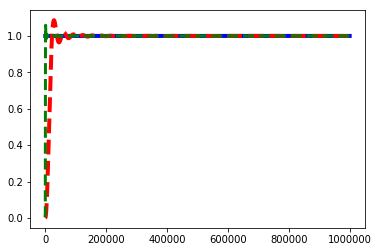

In [7]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

xc = xg.cpu()
x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))
gdottest(Dop_gpu, n, n, verb=True)

# y = Dx
y = Dop_gpu * x
print('y', y)

# xinv = D^-1 y
xinv = Dop / y
xinvg = (Dop_gpu / torch.from_numpy(y)).numpy() # solver only runs with torch tensors

plt.figure()
plt.plot(x, 'b', lw=4)
plt.plot(xinv, '--r', lw=4)
plt.plot(xinvg, '--g', lw=3);

In [8]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 765 µs per loop
10 loops, best of 3: 739 µs per loop


In [9]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 763 µs per loop
10 loops, best of 3: 1.86 ms per loop


Note here how we get hit by the cost of moving x and y back and forth between CPU and GPU.

Finally we consider the case of broadcasting, where the Diagonal operator is applied to single direction of the input vector x

In [10]:
n = int(1e5)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)
d = dg.cpu().numpy()
xg = (torch.ones(2*n, dtype=torch.float32)).to(dev)
x = xg.cpu().numpy()

Dop2 = Diagonal(d, dims=(n, 2), dir=0)
dottest(Dop2, 2*n, 2*n)

Dop2_gpu = gDiagonal(dg, device=dev, dims=(n, 2), dir=0)
gdottest(Dop2_gpu, 2*n, 2*n, device=dev)

True

In [11]:
%timeit -n 10 Dop2 * x
%timeit -n 10 Dop2_gpu * xg

10 loops, best of 3: 848 µs per loop
10 loops, best of 3: 34.9 µs per loop


And again moving back and forth from gpu to cpu

In [13]:
n = int(1e5)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)
d = dg.cpu().numpy()
xg = (torch.ones(2*n, dtype=torch.float32))
x = xg.cpu().numpy()

Dop2 = Diagonal(d, dims=(n, 2), dir=0)
dottest(Dop2, 2*n, 2*n)

Dop2_gpu = gDiagonal(dg, device=dev, dims=(n, 2), dir=0, togpu=(True, True), tocpu=(True, True))
gdottest(Dop2_gpu, 2*n, 2*n, device='cpu')

True

In [14]:
%timeit -n 10 Dop2 * x
%timeit -n 10 Dop2_gpu * xg

10 loops, best of 3: 810 µs per loop
10 loops, best of 3: 652 µs per loop


# MatrixMult

In [0]:
n = 2000
niter = 1000

Dot product (vector-vector)

In [16]:
z = np.ones(n, dtype=np.float32)
zgc = torch.ones(n, dtype=torch.float32)
zg = torch.ones(n, dtype=torch.float32).to(dev)

% timeit -n 40 -r 3 z.dot(z)
% timeit -n 40 -r 3 zgc.dot(zgc)
% timeit -n 40 -r 3 zg.dot(zg)
% timeit -n 40 -r 3 zg.matmul(zg)
% timeit -n 40 -r 3 torch.sum(zg*zg)

40 loops, best of 3: 740 ns per loop
40 loops, best of 3: 4.91 µs per loop
40 loops, best of 3: 62.8 µs per loop
40 loops, best of 3: 68.4 µs per loop
The slowest run took 5.07 times longer than the fastest. This could mean that an intermediate result is being cached.
40 loops, best of 3: 29.9 µs per loop


Dot product (matrix-vector)

In [17]:
A = np.random.randn(n, n).astype(np.float32)
Agc = torch.from_numpy(A)
Ag = torch.from_numpy(A).to(dev)
zgg = zg.reshape(n, 1)

% timeit -n 40 -r 3 A.dot(z)
% timeit -n 40 -r 3 np.matmul(A, z)
% timeit -n 40 -r 3 Agc.matmul(zgc)
% timeit -n 40 -r 3 Ag.matmul(zg)
% timeit -n 40 -r 3 Ag.mm(zgg)

40 loops, best of 3: 283 µs per loop
40 loops, best of 3: 297 µs per loop
40 loops, best of 3: 545 µs per loop
40 loops, best of 3: 12.6 µs per loop
40 loops, best of 3: 10.9 µs per loop


We can see how numpy's dot product seem to always win for vector-vector computations but in case of matrix-matrix pytorch on cuda outperforms numpy when n grows (roughly n>500)

In [0]:
def conjgrad(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A._matvec(x)
    d = r.copy()
    k = r.dot(r)
    for iter in range(niter):
        #if iter == 0:
        #  Ad = A._matvec(r)
        #  dAd = r.dot(Ad)
        #else:
        Ad = A._matvec(d)
        dAd = d.dot(Ad)
        a = k / dAd
        x += a*d
        r -= a*Ad
        kold = k
        k = r.dot(r)
        b = k / kold
        d = r + b*d;
    return x
  
def conjgrad_gpu(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A.matmul(x)
    d = r.clone()
    kold = torch.sum(r*r)
    for iter in range(niter):
        Ad = A.matmul(d)
        dAd = torch.sum(d*Ad)
        a = kold / dAd
        x += a*d
        r -= a*Ad
        k = torch.sum(r*r)
        b = k / kold
        d = r + b*d;
        kold = k
    return x

1.336560341676711


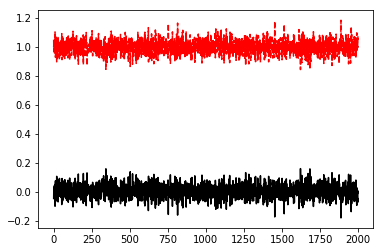

In [19]:
np.random.seed(10)
x = np.ones(n, dtype=np.float32)
A = np.random.randn(n, n).astype(np.float32)
ATA = np.dot(A.T, A)

Aop = MatrixMult(ATA)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, maxiter=niter)[0]
xinv = conjgrad(Aop, y, np.zeros_like(x), niter)
print(np.linalg.norm(xinv - xinv_sp))

plt.figure()
plt.plot(x)
plt.plot(xinv_sp, '--r')
plt.plot(x-xinv_sp, 'k')

0.1477798


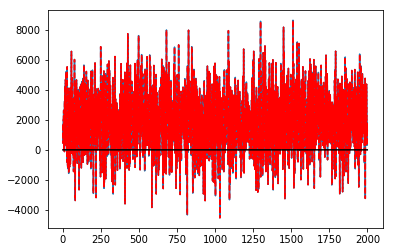

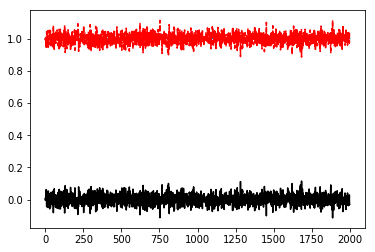

In [20]:
xg = torch.ones(n, dtype=torch.float32).to(dev)
x0g = torch.zeros(n, dtype=torch.float32).to(dev)
Ag = torch.from_numpy(A).to(dev)
ATAg = torch.matmul(Ag.t(), Ag)

yg = ATAg.matmul(xg)
plt.figure()
plt.plot(y)
plt.plot(yg.cpu().numpy(), '--r')
plt.plot(y-yg.cpu().numpy(), 'k')

xinvg = conjgrad_gpu(ATAg, yg, torch.zeros(n, dtype=torch.float32).to(dev), niter)
print(np.linalg.norm(xinv - xinvg.cpu().numpy()))

plt.figure()
plt.plot(x)
plt.plot(xinvg.cpu().numpy(), '--r')
plt.plot(x-xinvg.cpu().numpy(), 'k')

0.1477798


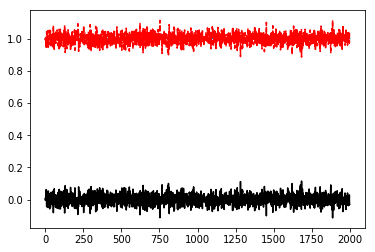

In [21]:
Agop = gMatrixMult(ATAg, device=dev)

xinvg = gcg(Agop, yg, x=torch.zeros(n, dtype=torch.float32).to(dev), niter=niter)[0]
print(np.linalg.norm(xinv - xinvg.cpu().numpy()))

plt.figure()
plt.plot(x)
plt.plot(xinvg.cpu().numpy(), '--r')
plt.plot(x-xinvg.cpu().numpy(), 'k')

In [22]:
niter = 3

%timeit -n 2 cg(Aop, y, maxiter=niter)[0]
%timeit -n 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 conjgrad_gpu(ATAg, yg, x0g, niter)
%timeit -n 2 gcg(Agop, yg, x=torch.zeros(n, dtype=torch.float32).to(dev), niter=niter)

2 loops, best of 3: 31.5 ms per loop
2 loops, best of 3: 2.24 ms per loop
2 loops, best of 3: 952 µs per loop
2 loops, best of 3: 1.33 ms per loop


In [23]:
niter = 500

%timeit -n 2 -r 2 cg(Aop, y, maxiter=niter)[0]
%timeit -n 2 -r 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 -r 2 conjgrad_gpu(ATAg, yg, x0g, niter)
%timeit -n 2 gcg(Agop, yg, x=torch.zeros(n, dtype=torch.float32).to(dev), niter=niter)[0]

2 loops, best of 2: 3.23 s per loop
2 loops, best of 2: 289 ms per loop
2 loops, best of 2: 122 ms per loop
2 loops, best of 3: 139 ms per loop


For large enough problems the gpu implementation of cg seem to greatly outperform scipy as well as our CPU implementation (mostly because the speedup in matrix-vector computation outreaches the slow down in  vector-vector).

# 1D Convolution

In [24]:
N = 11
Nh = 3
x = np.zeros(N)
x[N//2] = 1

h = np.arange(Nh)+1
y = np.convolve(x, h, mode='same')
print(y)

[0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]


In [25]:
xt = torch.zeros(N)
xt[N//2] = 1

ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
yt = torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, ht.size()[0]), padding=ht.size()[0]//2)

xc = xt.to(dev)
hc = ht.to(dev)
yc = torch.torch.conv_transpose1d(xc.reshape(1, 1, N), hc.reshape(1, 1, hc.size()[0]), padding=hc.size()[0]//2)

print(yt)
print(yc)

tensor([[[0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 0.]]])
tensor([[[0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 0.]]], device='cuda:0')


In [26]:
y = np.correlate(x, h, mode='same')
print(y)

yt = torch.torch.conv1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)

[0. 0. 0. 0. 3. 2. 1. 0. 0. 0. 0.]
tensor([[[0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0.]]])


In [27]:
N = 5001
Nh = 301
x = np.zeros(N)
x[N//2] = 1
h = np.arange(Nh)+1

xt = torch.zeros(N)
xt[N//2] = 1

ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
yt = torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, ht.size()[0]), padding=ht.size()[0]//2)

xc = xt.to(dev)
hc = ht.to(dev)

%timeit -n 100 -r 3 np.convolve(x, h, mode='same')
%timeit -n 100 -r 3 torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, ht.size()[0]), padding=ht.size()[0]//2)
%timeit -n 100 -r 3 torch.torch.conv_transpose1d(xc.reshape(1, 1, N), hc.reshape(1, 1, hc.size()[0]), padding=hc.size()[0]//2)

%timeit -n 100 -r 3 np.correlate(x, h, mode='same')
%timeit -n 100 -r 3 torch.torch.conv1d(xt.reshape(1, 1, N), ht.reshape(1, 1, ht.size()[0]), padding=ht.size()[0]//2)
%timeit -n 100 -r 3 torch.torch.conv1d(xc.reshape(1, 1, N), hc.reshape(1, 1, hc.size()[0]), padding=hc.size()[0]//2)

100 loops, best of 3: 394 µs per loop
100 loops, best of 3: 2.91 ms per loop
100 loops, best of 3: 66.7 µs per loop
100 loops, best of 3: 384 µs per loop
100 loops, best of 3: 2.7 ms per loop
100 loops, best of 3: 65.8 µs per loop


Let's repeat this for 2d signals, with convolution performed only on one axis

In [28]:
N = 11
Nh = 3
xt = torch.zeros((1000, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt.shape)
yc = torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)
print(yc.shape)

% timeit -n 100 -r 3 torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit -n 100 -r 3 torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

torch.Size([1000, 1, 11])
torch.Size([1000, 1, 11])
100 loops, best of 3: 537 µs per loop
100 loops, best of 3: 67.9 µs per loop


In [29]:
xt = torch.zeros((1000, 10, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000*10, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
yc = torch.torch.conv1d(xc.reshape(1000*10, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

% timeit -n 100 -r 3 torch.torch.conv1d(xt.reshape(1000*10, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit -n 100 -r 3 torch.torch.conv1d(xc.reshape(1000*10, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

100 loops, best of 3: 3.55 ms per loop
100 loops, best of 3: 67.6 µs per loop


Let's use the operator

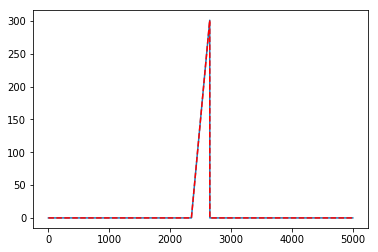

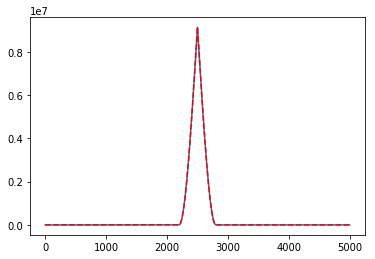

In [30]:
N = 5001
Nh = 301
x = np.zeros(N)
x[N//2] = 1
xt = torch.zeros(N)
xt[N//2] = 1
xc = xt.to(dev)

h = np.arange(Nh)+1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
hc = ht.to(dev)

Cop = Convolve1D(N, h, offset=Nh//2)
dottest(Cop, N, N)
y = Cop * x
xadj = Cop.H * y

gCop = gConvolve1D(N, hc, offset=Nh//2, device=dev)
gdottest(gCop, N, N, device=dev)
yc = gCop * xc
xadjc = gCop.H * yc

plt.figure()
plt.plot(y)
plt.plot(yc.cpu().numpy(), '--r')

plt.figure()
plt.plot(xadj)
plt.plot(xadjc.cpu().numpy(), '--r')

In [31]:
% timeit -n 100 -r 3 Cop * x
% timeit -n 100 -r 3 gCop * xc

100 loops, best of 3: 425 µs per loop
100 loops, best of 3: 90.8 µs per loop


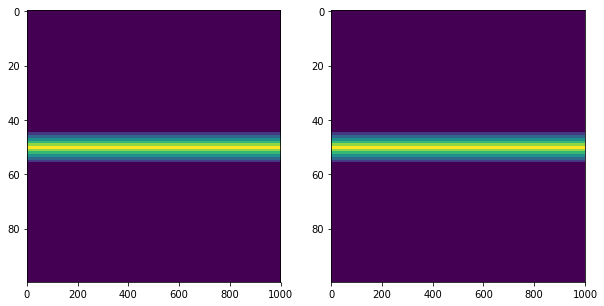

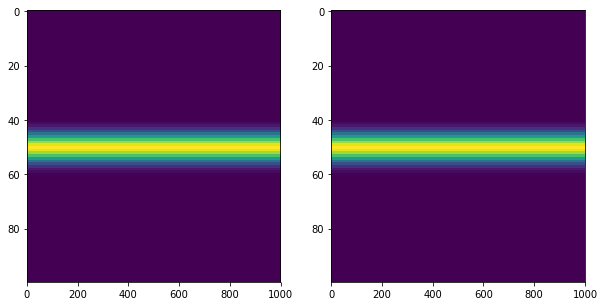

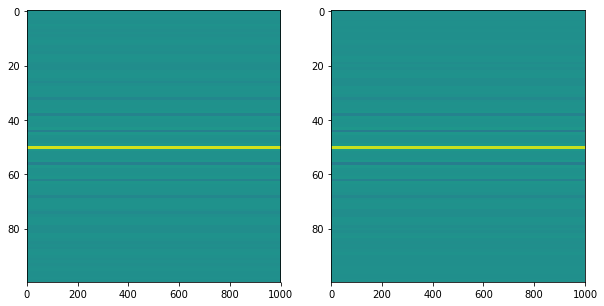

In [32]:
N = 100
Nh = 11
Nx = 1000
x = np.zeros((N, Nx))
x[N//2] = 1
xt = torch.zeros((N, Nx))
xt[N//2] = 1
xc = xt.to(dev)

h = triang(Nh)
ht = torch.from_numpy(h.astype(np.float32))
hc = ht.to(dev)

Cop = Convolve1D(N*Nx, h, offset=Nh//2, dims=(N, Nx))
dottest(Cop, N*Nx, N*Nx)
y = Cop * x.ravel()
xadj = Cop.H * y
xinv = conjgrad(Cop.H*Cop, Cop.H*y, np.zeros_like(x.ravel()), 100) # cg(Cop.H*Cop, Cop.H*y, maxiter=100)[0]

gCop = gConvolve1D(N*Nx, hc, offset=Nh//2, dims=(N, Nx), device=dev)
gdottest(gCop, N*Nx, N*Nx, device=dev)
yc = gCop * xc.view(-1)
xadjc = gCop.H * yc
xinvc = gcg(gCop.H*gCop, gCop.H*yc, niter=100)[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(y.reshape(N, Nx))
axs[0].axis('tight')
axs[1].imshow(yc.cpu().numpy().reshape(N, Nx))
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(xadj.reshape(N, Nx))
axs[0].axis('tight')
axs[1].imshow(xadjc.cpu().numpy().reshape(N, Nx))
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(xinv.reshape(N, Nx), vmin=-1, vmax=1)
axs[0].axis('tight')
axs[1].imshow(xinvc.cpu().numpy().reshape(N, Nx), vmin=-1, vmax=1)
axs[1].axis('tight');

In [33]:
% timeit -n 5 -r 3 conjgrad(Cop.H*Cop, Cop.H*y, np.zeros_like(x.ravel()), 50)
% timeit -n 5 -r 3 gcg(gCop.H*gCop, gCop.H*yc, niter=50)[0]

5 loops, best of 3: 792 ms per loop
5 loops, best of 3: 91.6 ms per loop


# FirstDerivative

Let's try now to compute derivatives by means of Convolve1D

In [34]:
nx = 101
x = np.zeros(nx, dtype=np.float32)
x[nx//2] = 1
x[nx//3] = 1
x[nx-4] = 1
xc = torch.torch.from_numpy(x).to(dev)

Dop = FirstDerivative(nx, edge=True)
Dconvop = Convolve1D(nx, np.array([0.5, 0, -0.5], dtype=np.float32), offset=1)
gDconvop = gConvolve1D(nx, torch.torch.tensor([0.5, 0, -0.5], dtype=torch.float32).to(dev), offset=1)

y = Dop*x
yconv = Dconvop*x
yc = gDconvop*xc

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjc = gDconvop.H*yc

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, yc.cpu().numpy()))
print(np.allclose(xadj, xadjc.cpu().numpy()))

True
True
True
True


In [36]:
%timeit -n 50 -r 3 Dop.matvec(x.ravel())
%timeit -n 50 -r 3 Dconvop.matvec(x.ravel())

%timeit -n 50 -r 3 Dop.rmatvec(y)
%timeit -n 50 -r 3 Dconvop.rmatvec(y)

50 loops, best of 3: 24.4 µs per loop
50 loops, best of 3: 10.2 µs per loop
50 loops, best of 3: 15.6 µs per loop
50 loops, best of 3: 12.7 µs per loop


And for a 3-dimensional input

In [50]:
nt, nx, ny = 101, 201, 101
x = np.zeros((nt, nx, ny), dtype=np.float32)
x[nt//2] = 1
x[nt//3] = 1
x[nt-4] = 1
xc = torch.torch.from_numpy(x).to(dev)

Dop = FirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=0)
Dconvop = Convolve1D(nx*nt*ny, np.array([0.5, 0, -0.5]), 
                     dims=(nt, nx, ny), offset=1, dir=0)
#gDconvop = gConvolve1D(nx*nt*ny, torch.torch.tensor([0.5, 0, -0.5], dtype=torch.float32).to(dev), 
#                       dims=(nt, nx, ny), offset=1, dir=0)
gDconvop = gFirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=0, device=dev, dtype=torch.float32)


y = Dop*x.ravel()
yconv = Dconvop*x.ravel()
yc = gDconvop*xc.view(-1)

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjc = gDconvop.H*yc

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, yc.cpu().numpy()))
print(np.allclose(xadj, xadjc.cpu().numpy()))

True
True
True
True


In [51]:
x = x.ravel()
xc = xc.view(-1)

%timeit -n 20 -r 3 Dop.matvec(x)
%timeit -n 20 -r 3 Dconvop.matvec(x)
%timeit -n 20 -r 3 gDconvop.matvec(xc)

%timeit -n 20 -r 3 Dop.rmatvec(y)
%timeit -n 20 -r 3 Dconvop.rmatvec(y)
%timeit -n 20 -r 3 gDconvop.rmatvec(yc)

20 loops, best of 3: 8.38 ms per loop
20 loops, best of 3: 170 ms per loop
20 loops, best of 3: 145 µs per loop
20 loops, best of 3: 20.1 ms per loop
20 loops, best of 3: 166 ms per loop
20 loops, best of 3: 140 µs per loop


In [52]:
nt, nx, ny = 101, 201, 101
x = np.zeros((nt, nx, ny), dtype=np.float32)
x[...,ny//2] = 1
x[...,ny//3] = 1
x[...,ny-4] = 1
xc = torch.torch.from_numpy(x).to(dev)

Dop = FirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=2)
Dconvop = Convolve1D(nx*nt*ny, np.array([0.5, 0, -0.5]), 
                     dims=(nt, nx, ny), offset=1, dir=2)
#gDconvop = gConvolve1D(nx*nt*ny, torch.torch.tensor([0.5, 0, -0.5], dtype=torch.float32).to(dev), 
#                       dims=(nt, nx, ny), offset=1, dir=2, device=dev)
gDconvop = gFirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=2, device=dev, dtype=torch.float32)


y = Dop*x.ravel()
yconv = Dconvop*x.ravel()
yc = gDconvop*xc.view(-1)

xadj = Dop.H*y
xadjconv = Dconvop.H*y
xadjc = gDconvop.H*yc

print(np.allclose(y, yconv))
print(np.allclose(xadj, xadjconv))

print(np.allclose(y, yc.cpu().numpy()))
print(np.allclose(xadj, xadjc.cpu().numpy()))

True
True
True
True


In [53]:
x = x.ravel()
xc = xc.view(-1)

%timeit -n 20 -r 3 Dop.matvec(x)
%timeit -n 20 -r 3 Dconvop.matvec(x)
%timeit -n 20 -r 3 gDconvop.matvec(xc)

%timeit -n 20 -r 3 Dop.rmatvec(y)
%timeit -n 20 -r 3 Dconvop.rmatvec(y)
%timeit -n 20 -r 3 gDconvop.rmatvec(yc)

20 loops, best of 3: 29.7 ms per loop
20 loops, best of 3: 113 ms per loop
20 loops, best of 3: 87.5 µs per loop
20 loops, best of 3: 49.3 ms per loop
20 loops, best of 3: 116 ms per loop
20 loops, best of 3: 85.5 µs per loop


Finally moving things back and forth from CPU to GPU

In [54]:
#gDconvop = gConvolve1D(nx*nt*ny, torch.torch.tensor([0.5, 0, -0.5], dtype=torch.float32).to(dev), 
#                       dims=(nt, nx, ny), offset=1, dir=0, device=dev,
#                       togpu=(True, True), tocpu=(True, True))
gDconvop = gFirstDerivative(nx*nt*ny, dims=(nt, nx, ny), dir=0, device=dev,
                       togpu=(True, True), tocpu=(True, True), dtype=torch.float32)

xc = xc.cpu()
yc = yc.cpu()

%timeit -n 20 -r 3 Dop.matvec(x)
%timeit -n 20 -r 3 Dconvop.matvec(x)
%timeit -n 20 -r 3 gDconvop.matvec(xc)

%timeit -n 20 -r 3 Dop.rmatvec(y)
%timeit -n 20 -r 3 Dconvop.rmatvec(y)
%timeit -n 20 -r 3 gDconvop.rmatvec(yc)

20 loops, best of 3: 29.2 ms per loop
20 loops, best of 3: 118 ms per loop
20 loops, best of 3: 7.93 ms per loop
20 loops, best of 3: 50.3 ms per loop
20 loops, best of 3: 114 ms per loop
20 loops, best of 3: 6.19 ms per loop


We can see how in this case the derivative is faster even with the overhead of moving things from GPU to CPU and back